# Task III - Estimating SLA Conformance and Violation from Device Statistics

## 1. Model Training - use Logistic Regression to train a classifier C with the training set. Provide the coefficients (Θ 0 , ..., Θ 12 ) of your model C. (Θ 0 is the offset.)

Please add or correct following issues in your final report. 

- Compare the FN and FP and explain which one is more important form service provider's perspective? why? 

- Your naive estimator is not correct. Please correct it for final version. You need to compute the probability of having Y=1 in your training (P) (which you computed). Then you have to generate 1080 random numbers with probability of P and if it is grater than P set it to 1 otherwise 0. Then compute ERR for this values.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

X = pd.read_csv('data/X.csv')
Y = pd.read_csv('data/Y.csv')
Y['TimeStamp'] = Y.TimeStamp.astype(int)

X.index = pd.to_datetime(
    X['TimeStamp'], unit='s')
Y.index = pd.to_datetime(
    Y['TimeStamp'], unit='s')

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7)

# minimum dispframes in SLA: 18 frames/sec
min_disp_frames = 18.0

# Labeling the y_training
y_train_sla_label = np.array(
    y_train['DispFrames'] >= min_disp_frames).astype(int)

logisticRegr = LogisticRegression(C=1e5, solver='lbfgs', 
    multi_class='multinomial')

X_train = X_train.drop(['TimeStamp'], axis=1)
logisticRegr.fit(X_train, y_train_sla_label)

for idx, col_name in enumerate(X_train.columns):
    print("{} The coefficient for {} is {}".format(idx+1, col_name,
                                                   np.round(logisticRegr.coef_[0][idx], decimals=3)))

intercept = np.round(logisticRegr.intercept_[0], decimals=3)
print("The intercept for our model is (teta 0) {}".format(intercept))

1 The coefficient for runq-sz is -0.024
2 The coefficient for %%memused is 0.033
3 The coefficient for proc/s is 0.006
4 The coefficient for cswch/s is -0.0
5 The coefficient for all_%%usr is 0.004
6 The coefficient for ldavg-1 is -0.001
7 The coefficient for totsck is 0.009
8 The coefficient for pgfree/s is -0.0
9 The coefficient for plist-sz is -0.004
10 The coefficient for file-nr is 0.001
11 The coefficient for idel/s is -0.0
12 The coefficient for tps is -0.003
The intercept for our model is (teta 0) 0.0


## 2. Accuracy of the Classifiers C - Compute the classification error (ERR) on the test set for C.

ERR of logistic regression: 0.16759259259259263


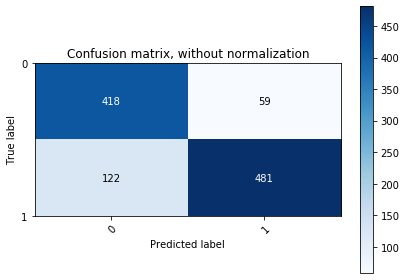

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# classify
prediction_result = logisticRegr.predict(X_test.drop(['TimeStamp'], axis=1))
y_test_merged = y_test.copy()
y_test_merged['predicted_sla'] = np.array(prediction_result)

# compute the confusion matrix, which includes the four numbers 
# True Positives (TP), True Negatives (TN), False Positives (FN), 
# and False Negatives (FN)
def compute_err(y_test_merged):
    arr = []
    TP = 0
    TN = 0
    for idx, row in y_test_merged.iterrows():
        if row['predicted_sla'] == 1:
            if row['DispFrames'] >= min_disp_frames:
                TP += 1
                arr.append('TP')
            else:
                #FP += 1
                arr.append('FP')
        else:
            if row['DispFrames'] < min_disp_frames:
                TN += 1
                arr.append('TN')
            else:
                #FN += 1
                arr.append('FN')

    y_test_merged['classification_error'] = np.array(arr)

    # compute the classification error
    err = 1 - (TP + TN) / len(y_test_merged.index)
    return err

print("ERR of logistic regression: {}".format(compute_err(y_test_merged)))

# example of plotting confusion map was taken from here:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    
    classes = classes[unique_labels(y_true.astype(int), y_pred.astype(int))]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            y_label_pos = i - 0.25 if i == 1 else i + 0.25
            ax.text(j, y_label_pos, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# 1 if pass SLA
# 0 if not pass SLA
y_true = [ 1 if row['DispFrames'] >= min_disp_frames else 0 
          for idx, row in y_test_merged.iterrows() ]
class_names = np.array([0, 1]).astype(int)
cm = confusion_matrix(y_true, prediction_result)
# Plot non-normalized confusion matrix
plot_confusion_matrix(np.array(y_true), prediction_result, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

### Analysis

This model, which is based on logistic regression, has classification error rate of 0.17129.

The confusion matrix summarizes how successful the model is in classifying the data. 

The left-top element of the matrix has value 0 for both true label and predicted label. This is "true negative", i.e., the model successfully label the data as "false", and the real data is also "false". 

The right-top element of the matrix has 0 on true label, but 1 on predicted label. This is "false positive", i.e., the model predicts the value as true, yet the real data says it is false.

The bottom-left element of the matrix has value 1 for the true label and 0 for predicted label. This is "false negative", i.e, the model predicts the value as false, yet the real data says it is true.

The bottom-right element of the matrix has value 1 for both true label and predicted label. This is "true positive", i.e., the model successfully predicts the value as true, and the real data is also true.

This confusion matrix shows that our logistic-based regression model can predict "false"/SLA violation correctly 416 times, and 132 times wrongly predict. It also shows that it is successfully predict "true"/passed SLA 479 times and 53 times has mistaken the prediction. These values (also the color; the darker the higher the value is) shows that the model is quite successful in predicting/classifying the data.

## 3. As a baseline for C, use a naı̈ve method which relies on Y values only. For each x ∈ X, the naı̈ve classifier predicts a value T rue with probability p and F alse with probability 1 − p. Compute p on the training set and the classification error for the naı̈ve classifier on the test set.

In [5]:
# p is the fraction of Y values that conform with the SLA
sla_conform = len(y_train[y_train['DispFrames'] >= 18.0].index)
print("sla_conform in training set: {}".format(sla_conform))
print("all training set: {}".format(len(y_train.index)))
p = sla_conform / len(y_train.index)
print("p: {}".format(p))

# calculating classification error for the naı̈ve classifier
import numpy

# https://stackoverflow.com/questions/43092317/setting-probability-of-getting-a-random-number-1-or-2
arr = []
for i in range(0, 1080):
    v = numpy.random.uniform(low=0.0, high=1.0)
    arr.append(1 if v < p else 0)

from collections import Counter
res = Counter(arr)
sla_conform_naive = res[1]
sla_not_conform_naive = res[0]
sla_conform_test = len(y_test[y_test['DispFrames'] >= 18.0].index)
sla_not_conform_test = len(y_test.index) - sla_conform_test

tp = min(sla_conform_naive, sla_conform_test)
tn = min(sla_not_conform_naive, sla_not_conform_test)

naive_err = 1 - (tp + tn) / len(y_test.index)
print("ERR of naive classification: {}".format(naive_err))

sla_conform in training set: 1397
all training set: 2520
p: 0.5543650793650794
ERR of naive classification: 0.010185185185185186


## 4. Build a new classifier by extending the linear regression function developed in Task II with a check on the output, i.e., the Video Frame Rate

In [6]:
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()
regression_model.fit(X_train, y_train.drop(['TimeStamp'], axis=1))

# predict with linear regression
y_predict_linear_reg = regression_model.predict(X_test.drop(['TimeStamp'], axis=1))

# then, the model built by linear regression is used to classify the SLA based on 
# Y values
prediction_result_linear_reg = np.array(
    np.where(y_predict_linear_reg >= min_disp_frames, 1, 0)).flatten()

# classification error for this new classifier on the test set
y_test_merged_w_linear_reg = y_test.copy()
y_test_merged_w_linear_reg['predicted_sla'] = np.array(prediction_result_linear_reg)
linear_reg_err = compute_err(y_test_merged_w_linear_reg)
print("ERR of linear regression-based model: {}".format(linear_reg_err))

ERR of linear regression-based model: 0.15833333333333333


## The comparison of the classification errors of the models

We have three models and their classification error values:

- Logistic regression-based model's error: 0.17129
- Naive (y values-only) error: 0.44907
- Linear regression (and extended)-based model's error: 0.17222

The classification error describes how reliable the model is. The higher the error value is, the less reliable the model will be. If we sort the error in increasing order, the sequence is as follows: logistic regression-based model, linear regression-based model, naive model. We can conclude that logistic regression-based and linear regression-based is quite reliable, but the naive model is not that reliable.

The reason why the errors differ lies on how the model is build. The naive error only relies on the probability of y=1. The probability is taken from the training set. This is not reliable because of 2 reasons: the training set and the test set might not be evenly distributed and it does not take any x values into consideration.

On the other hand, the regression model, both logistic and linear, takes x values into consideration. Most importantly, it tries to minimize the cost function when building the model (finding the coefficients) in order to be as precise as possible. This makes the regression-based models much reliable (i.e., smaller classification errors) than the naive model.